In [14]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skopt.space import Real, Categorical, Integer

from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.utils import get_dir

In [15]:
# Define the search space
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_nested_size': Integer(16, 1024),
    'model_nested_layers': Integer(1, 8),
    'model_n_blocks': Integer(4, 32),
    'model_act_norm': Categorical([True, False]),
    'model_dropout': Real(0.0, 0.5),
    'feature_network_hidden_size': Integer(16, 256),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0.0, 0.5),
}

In [16]:
checkpoint_file = os.path.join(get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2", create=True), 'checkpoint_improved.pkl')
metrics_dir = get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2", "metrics", create=True)

print(os.path.abspath(checkpoint_file))
print(os.path.abspath(metrics_dir))

/home/psaegert/Projects/bcnf/models/bcnf-models/hyperparameter_optimization/stage_2/checkpoint_improved.pkl
/home/psaegert/Projects/bcnf/models/bcnf-models/hyperparameter_optimization/stage_2/metrics


In [17]:
with open(checkpoint_file, 'rb') as f:
    checkpoint = pickle.load(f, errors='ignore')

In [18]:
metrics = {}
for metrics_file in os.listdir(metrics_dir):
    with open(os.path.join(metrics_dir, metrics_file), 'rb') as f:
        metrics[os.path.splitext(metrics_file)[0].replace('params_', '')] = pickle.load(f)

In [19]:
rows = [params + [value] for params, value in zip(checkpoint['x_iters'], checkpoint['func_vals'])]

In [20]:
hyper_df = pd.DataFrame(rows, columns=list(search_spaces.keys()) + ['val_loss_upper_bound'])

# Add the configuration name
hyper_df['configuration_name'] = hyper_df.apply(lambda row: "_".join([str(p) for p in row.values[:-1]]), axis=1)

# Set all columns in 'loss' that are = 100 to nan
hyper_df.loc[hyper_df['val_loss_upper_bound'] == 100, 'val_loss_upper_bound'] = None

# Round the values
hyper_df['model_dropout'] = hyper_df['model_dropout'].round(3)
hyper_df['feature_network_dropout'] = hyper_df['feature_network_dropout'].round(3)
hyper_df['val_loss_upper_bound'] = hyper_df['val_loss_upper_bound'].round(3)

In [21]:
len(hyper_df)

4

In [22]:
hyper_df.sort_values('val_loss_upper_bound')

,condition_size,model_nested_size,model_nested_layers,model_n_blocks,model_act_norm,model_dropout,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound,configuration_name
3,1536,128,5,16,False,0.115,58,3,0.065,16.777,1536_128_5_16_False_0.11538461538461539_58_3_0...
0,1,16,1,4,False,0.000,16,0,0.000,28.205,1_16_1_4_False_0.0_16_0_0.0
1,1024,352,2,8,False,0.038,30,1,0.022,51.693,1024_352_2_8_False_0.038461538461538464_30_1_0...
2,513,688,4,12,False,0.077,44,2,0.043,74.537,513_688_4_12_False_0.07692307692307693_44_2_0....


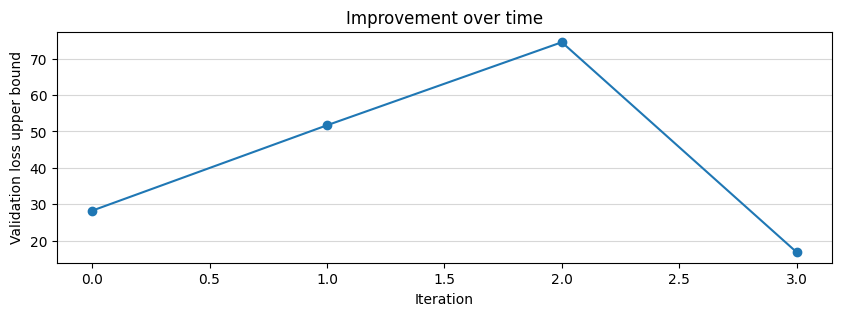

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(hyper_df['val_loss_upper_bound'], '-o')
# Plot nan values as red vertical lines
for i, val in enumerate(hyper_df['val_loss_upper_bound']):
    if np.isnan(val):
        ax.axvline(i, color='r', alpha=0.2, linestyle='--')
ax.set_title('Improvement over time')
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation loss upper bound')
ax.grid(axis='y', alpha=0.5)
# ax.set_ylim(None, 30);

In [24]:
# configuration = list(metrics.keys())[4]
# configuration = "1700_195_12_True_289_3_0.47366827208363227"
configuration = hyper_df.sort_values('val_loss_upper_bound').iloc[0]['configuration_name']

Text(0.5, 0.98, '1536_128_5_16_False_0.11538461538461539_58_3_0.06521739130434782')

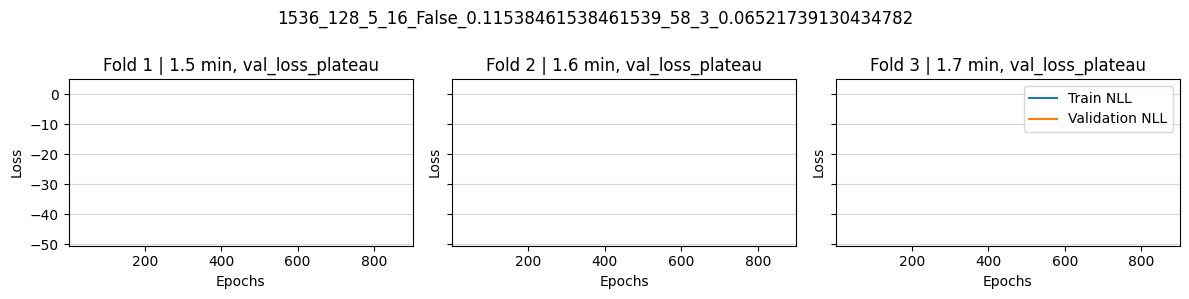

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    loss_history = metrics[configuration][i]['loss_history']
    epochs = np.array([e for e, _ in loss_history['train']])
    losses = np.array([l for _, l in loss_history['train']])

    ax.plot(epochs, losses, alpha=0.2, color='C0')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=128)), label='Train NLL', color='C0')

    epochs = np.array([e for e, _ in loss_history['val']])
    losses = np.array([l for _, l in loss_history['val']])

    ax.plot(epochs, losses, alpha=0.2, color='C1')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=32)), label='Validation NLL', color='C1')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    # ax.set_xscale('log')
    ax.set_ylim(None, 5)
    ax.set_xlim(1, None)
    ax.grid(axis='y', alpha=0.5)

    time_taken = loss_history['time'][-1][1] - loss_history['time'][0][1]
    ax.set_title(f'Fold {i+1} | {time_taken / 60:.1f} min, {loss_history["stop_reason"]}')

axes[-1].legend();

fig.tight_layout()
fig.subplots_adjust(top=0.75)
fig.suptitle(configuration)

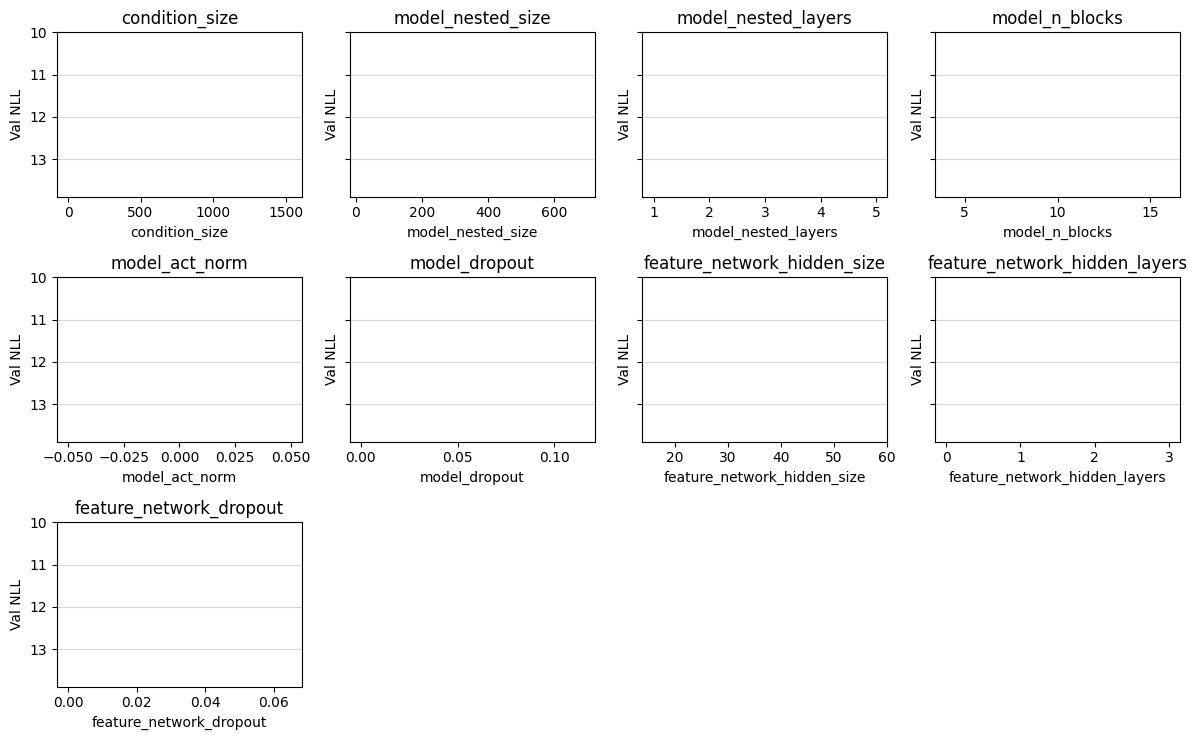

In [26]:
# Scatter the 'val_loss_upper_bound' column against the other columns
COLS = 4
ROWS = np.ceil(len(search_spaces) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2.5), sharey=True)

for i, (col, ax) in enumerate(zip(search_spaces.keys(), axes.flatten())):
    ax.scatter(hyper_df[col], hyper_df['val_loss_upper_bound'], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Val NLL')
    ax.grid(axis='y', alpha=0.5)
    ax.set_ylim(None, 10)

for ax in axes.flatten()[len(search_spaces):]:
    ax.remove()

fig.tight_layout()